<div style="text-align: right;">© 2025 Moses Boudourides. All Rights Reserved.</div>

## *instats* Workshop, March 9-12, 2025 
### https://instats.org/seminar/hypernetworks-in-theory-and-practice

# KEY METHODS OF HYPERGRAPH ANALYSIS
## Moses Boudourides

# IV. HYPERGRAPH METRICS AND DIRECTED GRAPHS

<span style="color:green">
    

### [1. Closeness Centrality](#1)
   
### [2. Harmonic Closeness Centrality](#2)

### [3. Eccentricity Centrality](#3)
    
### [4. Betweenness Centrality](#4)
    
### [5. Tudisco and Higham Linear Eigenvector Centrality](#5)
    
### [6. Tudisco and Higham Noninear (sublinear) Eigenvector Centrality](#6)
    
### [7. Tudisco and Higham Noninear (superlinear) Eigenvector Centrality](#7)
    
### [8. Tudisco and Higham Noninear (log plus one) Eigenvector Centrality](#8)
    
### [9. All Centralities of a Random Hypergraph](#9)
    
### [10. All Centralities of the Southern Women Hypergraph](#10)
    
### [11. All Centralities of the Clique-Based Karate Clique-Based Hypergraph](#11)
    
### [12. All Centralities of the Clique-Based Les Miserable Clique-Based Hypergraph](#12)
    
</span>

In [1]:
import pandas as pd
import numpy as np
import random
import string
import json
import math
import pickle
import itertools
from itertools import chain
from collections import Counter, defaultdict
lowercase_letters = list(string.ascii_lowercase)
uppercase_letters = list(string.ascii_uppercase)
import hypernetx as hnx
import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
all_colors = list(mcolors.CSS4_COLORS.keys())
cmap_list = ['tab20', 'tab10', 'Set1', 'Set2', 'Set3', 'Paired', 'Accent']
distinct_colors = [color for cmap in cmap_list for color in plt.get_cmap(cmap).colors] #[:50]
import pyvis
from pyvis.network import Network
from IPython.display import display, HTML, IFrame
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="hypernetx")

In [2]:
def hypergraph_random_creator(vertices, hyperedge_names, m, minv, maxv, mw):
    """
    Creates a random hypergraph with custom vertex and hyperedge names.

    Parameters:
    - vertices (list of int or str): List of vertex names.
    - hyperedge_names (list of str): List of hyperedge names.
    - m (int): Number of hyperedges to create (must be <= length of hyperedge_names).
    - minv (int): Minimum number of nodes in a hyperedge.
    - maxv (int): Maximum number of nodes in a hyperedge (must be > minv).
    - mw (int): Determines the vertex format.
        - If mw == 0 or mw == 1, the function returns the hypergraph dictionary.
        - If mw > 1, vertices are represented as dictionaries with keys as vertex names and values as random integers between 1 and mw.

    Returns:
    - hg_d (dict): A dictionary representing the hypergraph, with sorted node sets.
    """
    # Check if m is valid
    if m > len(hyperedge_names):
        raise ValueError("m cannot be greater than the number of hyperedge names provided.")
    
    hg_d = {}
    for k in range(m):
        r = random.randint(minv, maxv)
        nodes = random.sample(vertices, r)
        sorted_nodes = sorted(nodes)

        # If mw > 1, modify vertices to be dictionaries
        if mw > 1:
            sorted_nodes = {node: random.randint(1, mw) for node in sorted_nodes}
        
        hg_d[hyperedge_names[k]] = sorted_nodes
        
    return hg_d

def hgp_hnx(d):
    """
    Prints a hypergraph dictionary and plots the Euler diagram of the hypergraph using HyperNetX.
    """
    H = hnx.Hypergraph(d)
    hnx.drawing.draw(H)
    plt.show()
    
def is_connected(hypergraph):
    nodes = set([node for edge in hypergraph.values() for node in edge])
    visited = set()
    def dfs(node):
        visited.add(node)
        for edge in hypergraph.values():
            if node in edge:
                for neighbor in edge:
                    if neighbor not in visited:
                        dfs(neighbor)
    dfs(next(iter(nodes)))
    return visited == nodes

def TandH_nonlinear_hypergraph_centrality(H, f, tol=1e-6, max_iter=100):
    """
    Computes Tudisco & Higham nonlinear eigenvector centrality for both nodes and hyperedges in a hypergraph.

    Parameters:
    - H: dict mapping hyperedges to sets of nodes {hyperedge_id: {nodes}}
    - f: function defining the nonlinearity (e.g., f(x) = x**alpha for some alpha)
    - tol: float, tolerance for convergence
    - max_iter: int, maximum number of iterations

    Returns:
    - node_centrality: dict {node: centrality score}
    - edge_centrality: dict {hyperedge: centrality score}
    """
    nodes = {v for edge in H.values() for v in edge}  # Unique nodes
    edges = list(H.keys())  # Hyperedge identifiers
    
    n, m = len(nodes), len(edges)
    node_list, edge_list = list(nodes), list(edges)

    node_c = np.ones(n) / n  # Uniform node centrality
    edge_c = np.ones(m) / m  # Uniform hyperedge centrality

    for _ in range(max_iter):
        node_c_new = np.zeros(n)
        edge_c_new = np.zeros(m)

        for j, e in enumerate(edge_list):
            edge_c_new[j] = f(sum(node_c[node_list.index(v)] for v in H[e]))

        for i, v in enumerate(node_list):
            node_c_new[i] = f(sum(edge_c[edge_list.index(e)] for e in H if v in H[e]))

        node_c_new /= np.linalg.norm(node_c_new, ord=2)
        edge_c_new /= np.linalg.norm(edge_c_new, ord=2)

        if np.linalg.norm(node_c_new - node_c, ord=1) < tol and np.linalg.norm(edge_c_new - edge_c, ord=1) < tol:
            break
        
        node_c, edge_c = node_c_new, edge_c_new

    return {node_list[i]: node_c[i] for i in range(n)}, {edge_list[j]: edge_c[j] for j in range(m)}

def hypergraph_centralities(hypergraph, f, edges=True):
    H = hnx.Hypergraph(hypergraph)
    hg_d = hypergraph
    ff=2/((len(hg_d)-1)*(len(hg_d)-2))
    if edges:
        he_closeness = hnx.s_closeness_centrality(H, s=1, edges=True)
        he_hcloseness = hnx.s_harmonic_centrality(H, s=1)
        he_eccentricity = hnx.s_eccentricity(H, s=1)
        he_betweenness = hnx.s_betweenness_centrality(H, s=1)
        he_THeigenvector_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)[1]  # Hyperedge centrality
        df = pd.DataFrame({
            'Hyperedge': list(hypergraph.keys()),
            'Degree':[len(H.edges[e]) for e in hypergraph.keys()],
            'Closeness': [he_closeness[e] for e in hypergraph.keys()],
            'Harmonic Closeness': [ff*he_hcloseness[e] for e in hypergraph.keys()],
            'Eccentricity': [he_eccentricity[e] for e in hypergraph.keys()],
            'Betweenness': [he_betweenness[e] for e in hypergraph.keys()],
            'T&H Nonlinear Eigenvector': [he_THeigenvector_centrality[e] for e in hypergraph.keys()],
        })
    else:
        v_closeness = hnx.s_closeness_centrality(H, s=1, edges=False)
        v_hcloseness = hnx.s_harmonic_centrality(H, s=1, edges=False)
        v_eccentricity = hnx.s_eccentricity(H, s=1, edges=False)
        v_betweenness = hnx.s_betweenness_centrality(H, s=1, edges=False)
        v_THeigenvector_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)[0]  # Vertex centrality
        vertices = {v for edge in hypergraph.values() for v in edge}
        df = pd.DataFrame({
            'Vertex': list(vertices),
            'Degree':[H.degree(v) for v in vertices],
            'Closeness': [v_closeness[v] for v in vertices],
            'Harmonic Closeness': [ff*v_hcloseness[v] for v in vertices],
            'Eccentricity': [v_eccentricity[v] for v in vertices],
            'Betweenness': [v_betweenness[v] for v in vertices],
            'T&H Nonlinear Eigenvector': [v_THeigenvector_centrality[v] for v in vertices],
        })
    
    return df

def find_maximal_cliques(G):
    """
    Find all maximal cliques in the graph G using networkx's find_cliques function.
    
    Parameters:
    - G: A networkx graph
    
    Returns:
    - A list of sets, where each set contains the vertices of a maximal clique.
    """
    lists = nx.find_cliques(G)
    lists = [sorted(x) for x in lists]
    return sorted(list(lists), key=len, reverse=True)

def df2dict(df,col1,col2):
    d=dict(zip(df[col1],df[col2]))
    return d

<a id='1'></a>
## <span style="color:green">1. Closeness Centrality</span>

{'e1': [0], 'e2': [4, 6, 11, 12, 17, 19], 'e3': [9, 10, 16, 19], 'e4': [6, 11], 'e5': [3, 16], 'e6': [4, 6, 9, 10, 13, 17], 'e7': [0, 1, 3, 5, 10, 12], 'e8': [6, 14, 18]}


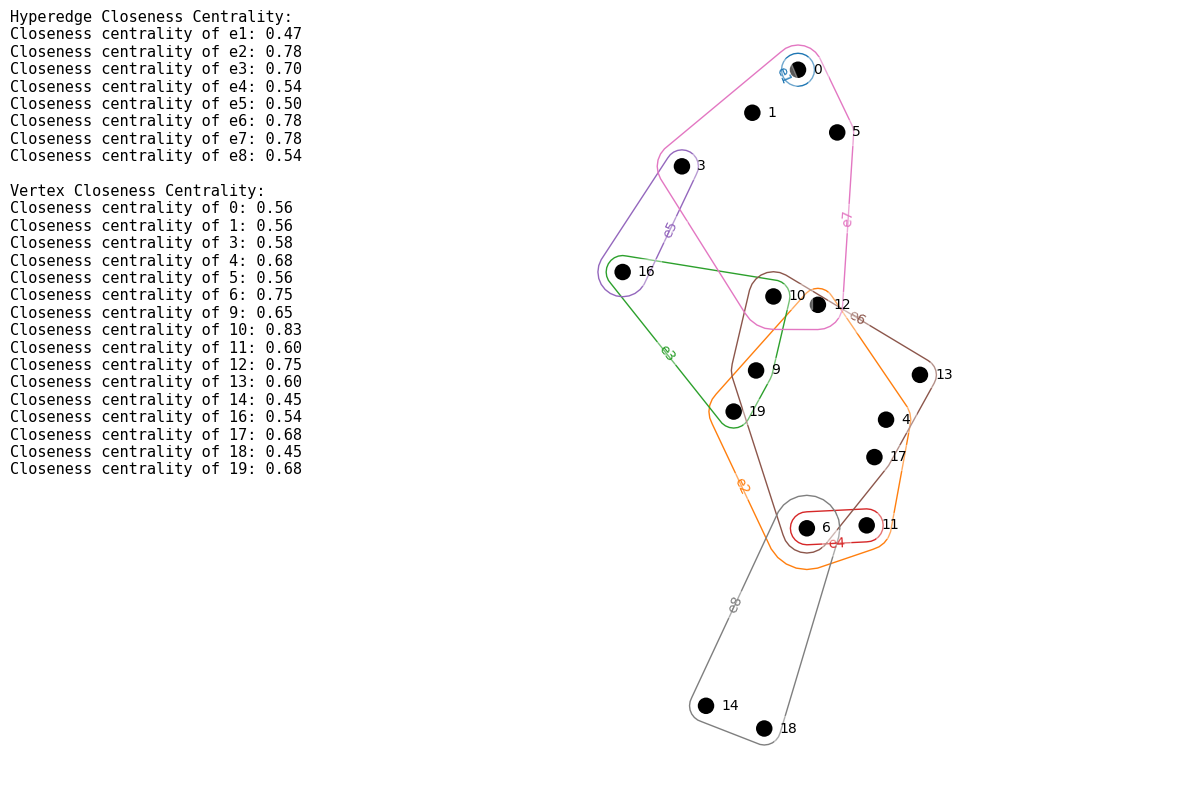

In [3]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []
text_output.append("Hyperedge Closeness Centrality:")
closeness=hnx.s_closeness_centrality(H, s=1) 
for k,v in closeness.items():
     text_output.append(f"Closeness centrality of {k}: {v:.2f}")

text_output.append("\nVertex Closeness Centrality:")
closeness=hnx.s_closeness_centrality(H, s=1, edges=False) 
for k,v in closeness.items():
     text_output.append(f"Closeness centrality of {k}: {v:.2f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='2'></a>
## <span style="color:green">2. Harmonic Closeness Centrality</span>

{'e1': [0, 5], 'e2': [2, 4, 8, 11, 15], 'e3': [12, 16], 'e4': [1, 2, 5, 8, 16, 17], 'e5': [1, 8, 10, 16], 'e6': [4, 5, 7, 16, 18], 'e7': [0, 3, 9, 11, 13, 16], 'e8': [7, 8, 14, 15, 18]}


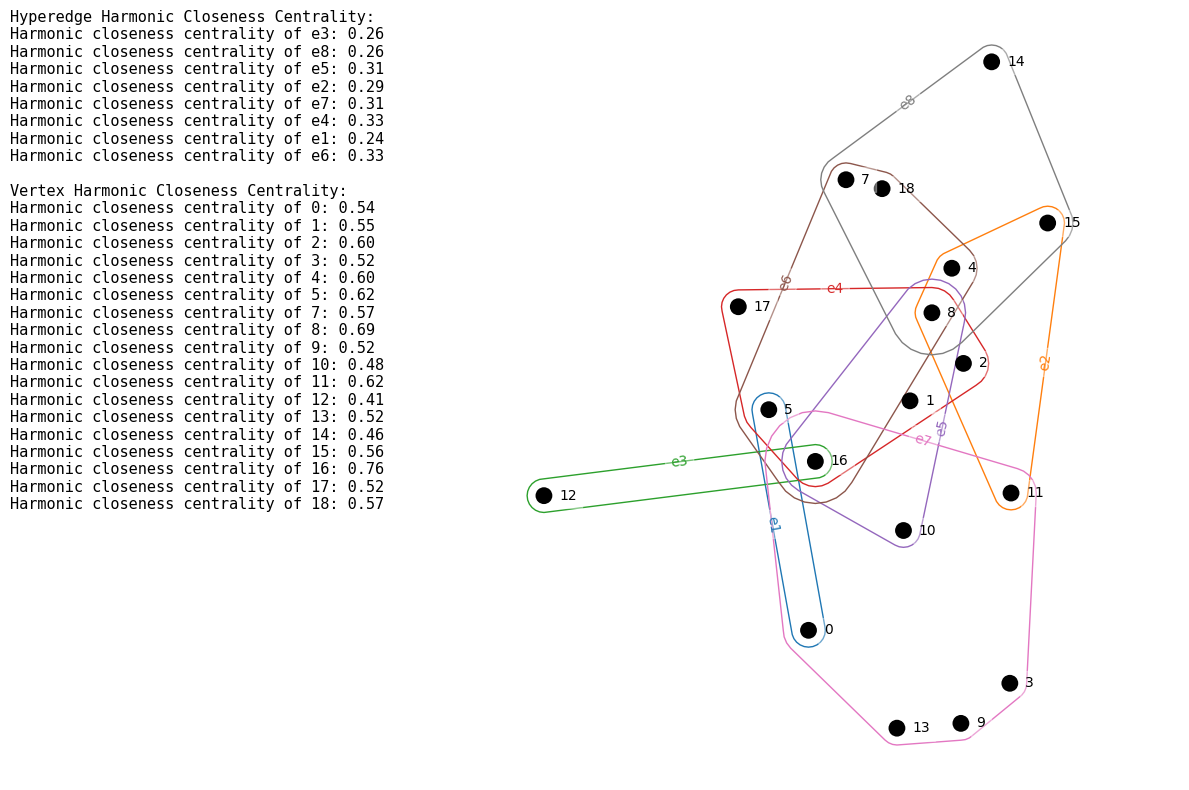

In [4]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)
ff=2/((len(hg_d)-1)*(len(hg_d)-2))

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

# text_output.append("Hyperedge Harmonic Closeness Centrality:")
# closeness=hnx.s_harmonic_closeness_centrality(H, s=1) 
# for k,v in closeness.items():
#      text_output.append(f"Harmonic closeness centrality of {k}: {v:.2f}")

text_output.append("Hyperedge Harmonic Closeness Centrality:")
hcloseness=hnx.s_harmonic_centrality(H, s=1) 
for k,v in hcloseness.items():
     text_output.append(f"Harmonic closeness centrality of {k}: {ff*v:.2f}")
        
text_output.append("\nVertex Harmonic Closeness Centrality:")
hcloseness=hnx.s_harmonic_centrality(H, s=1, edges=False) 
for k,v in hcloseness.items():
     text_output.append(f"Harmonic closeness centrality of {k}: {ff*v:.2f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='3'></a>
## <span style="color:green">3. Eccentricity Centrality</span>

{'e1': [7, 10, 11], 'e2': [8, 11, 13, 17, 18, 19], 'e3': [0, 2, 4, 17], 'e4': [3, 4, 12, 13, 16], 'e5': [6, 11, 15], 'e6': [0, 5, 14], 'e7': [3, 4, 11, 17], 'e8': [1, 2, 8, 15, 19]}


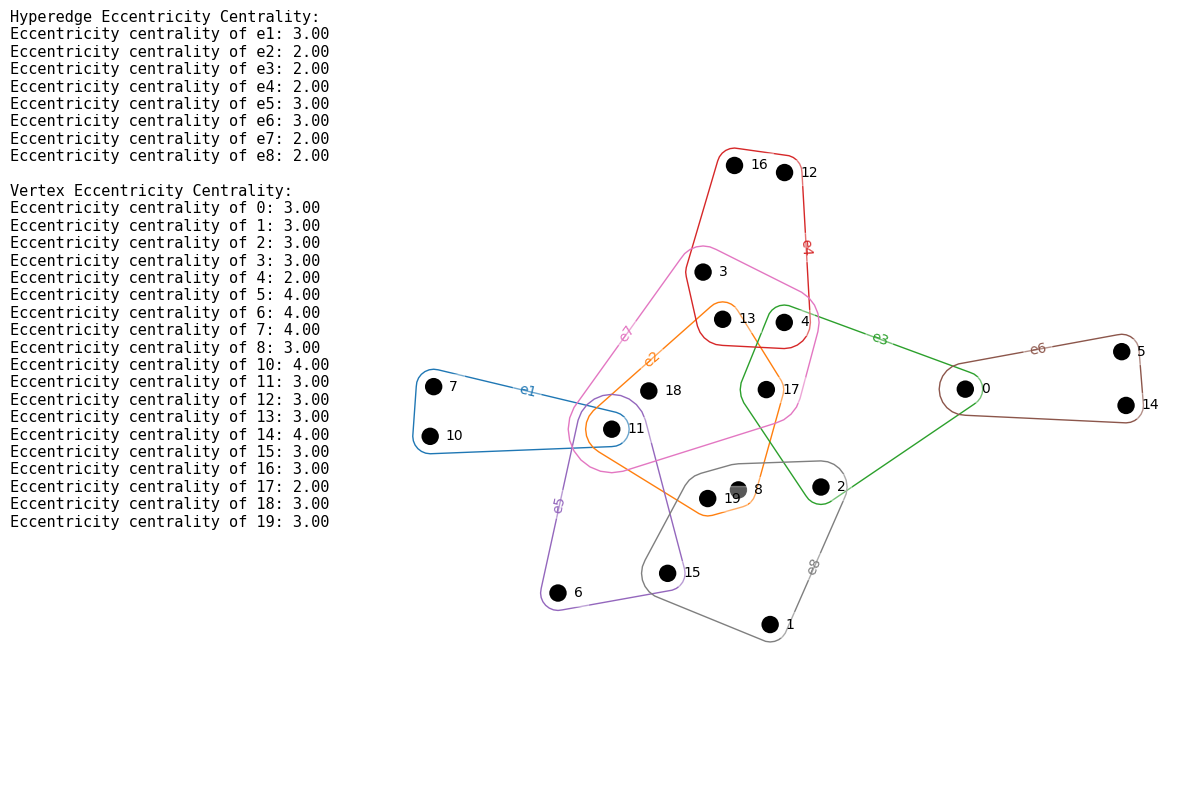

In [5]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("Hyperedge Eccentricity Centrality:")
eccentricity=hnx.s_eccentricity(H, s=1) 
for k,v in eccentricity.items():
     text_output.append(f"Eccentricity centrality of {k}: {v:.2f}")
        
text_output.append("\nVertex Eccentricity Centrality:")
eccentricity=hnx.s_eccentricity(H, s=1, edges=False) 
for k,v in eccentricity.items():
     text_output.append(f"Eccentricity centrality of {k}: {v:.2f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='4'></a>
## <span style="color:green">4. Betweenness Centrality</span>

{'e1': [1, 6, 8, 16], 'e2': [6, 11, 14, 15], 'e3': [4, 5, 6, 9, 12, 18], 'e4': [3, 12, 14, 15], 'e5': [4, 7], 'e6': [3, 4], 'e7': [0, 2, 3, 4, 15], 'e8': [7, 13, 17]}


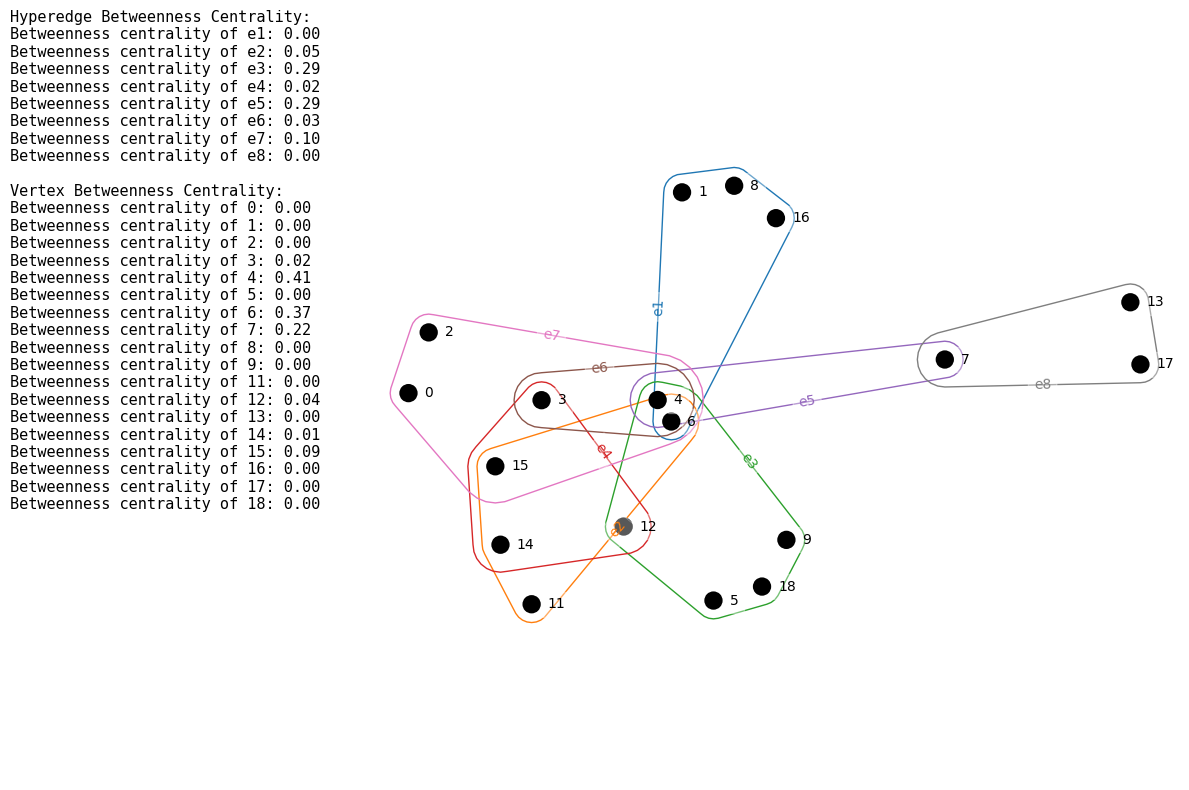

In [6]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break

print(hg_d)
H=hnx.Hypergraph(hg_d)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("Hyperedge Betweenness Centrality:")
betweenness=hnx.s_betweenness_centrality(H, s=1) 
for k,v in betweenness.items():
     text_output.append(f"Betweenness centrality of {k}: {v:.2f}") 
        
text_output.append("\nVertex Betweenness Centrality:")
betweenness=hnx.s_betweenness_centrality(H, s=1, edges=False) 
for k,v in betweenness.items():
     text_output.append(f"Betweenness centrality of {k}: {v:.2f}") 
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='5'></a>
## <span style="color:green">5. Tudisco and Higham Linear Eigenvector Centrality</span>

{'e1': [7, 10, 19], 'e2': [6], 'e3': [0, 2, 4, 15], 'e4': [1, 8, 9, 15, 17, 19], 'e5': [12, 16], 'e6': [9, 10, 12], 'e7': [9, 15, 19], 'e8': [1, 3, 6, 7, 10, 14]}


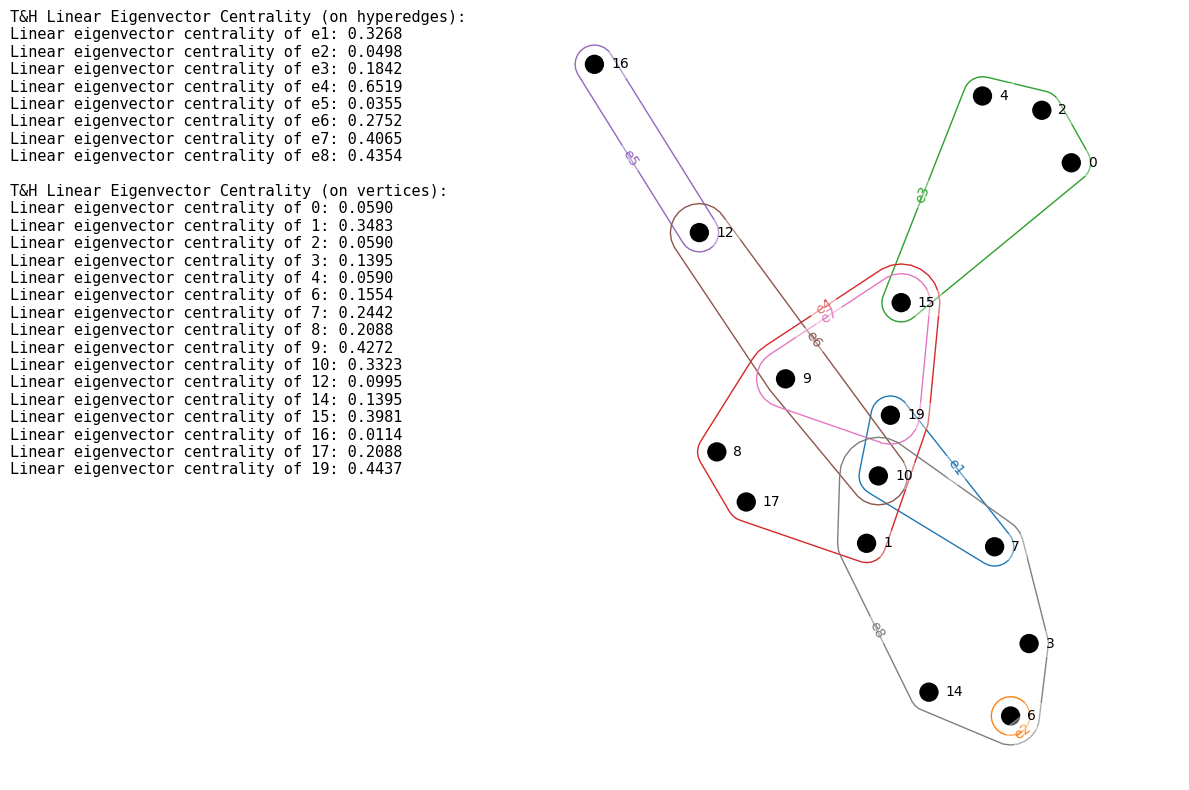

In [7]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break
print(hg_d)
H=hnx.Hypergraph(hg_d)        

alpha = 1
f = lambda x: x**alpha
node_centrality, edge_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("T&H Linear Eigenvector Centrality (on hyperedges):")
for k,v in edge_centrality.items():
     text_output.append(f"Linear eigenvector centrality of {k}: {v:.4f}")
        
text_output.append("\nT&H Linear Eigenvector Centrality (on vertices):")
for k,v in node_centrality.items():
     text_output.append(f"Linear eigenvector centrality of {k}: {v:.4f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='6'></a>
## <span style="color:green">6. Tudisco and Higham Noninear (sublinear) Eigenvector Centrality</span>

{'e1': [1, 10, 15, 18], 'e2': [1, 13], 'e3': [2, 11, 12, 16], 'e4': [10], 'e5': [2, 12, 15], 'e6': [5, 6, 7, 13, 16, 17], 'e7': [8, 16], 'e8': [0, 1, 4, 6, 8, 11]}


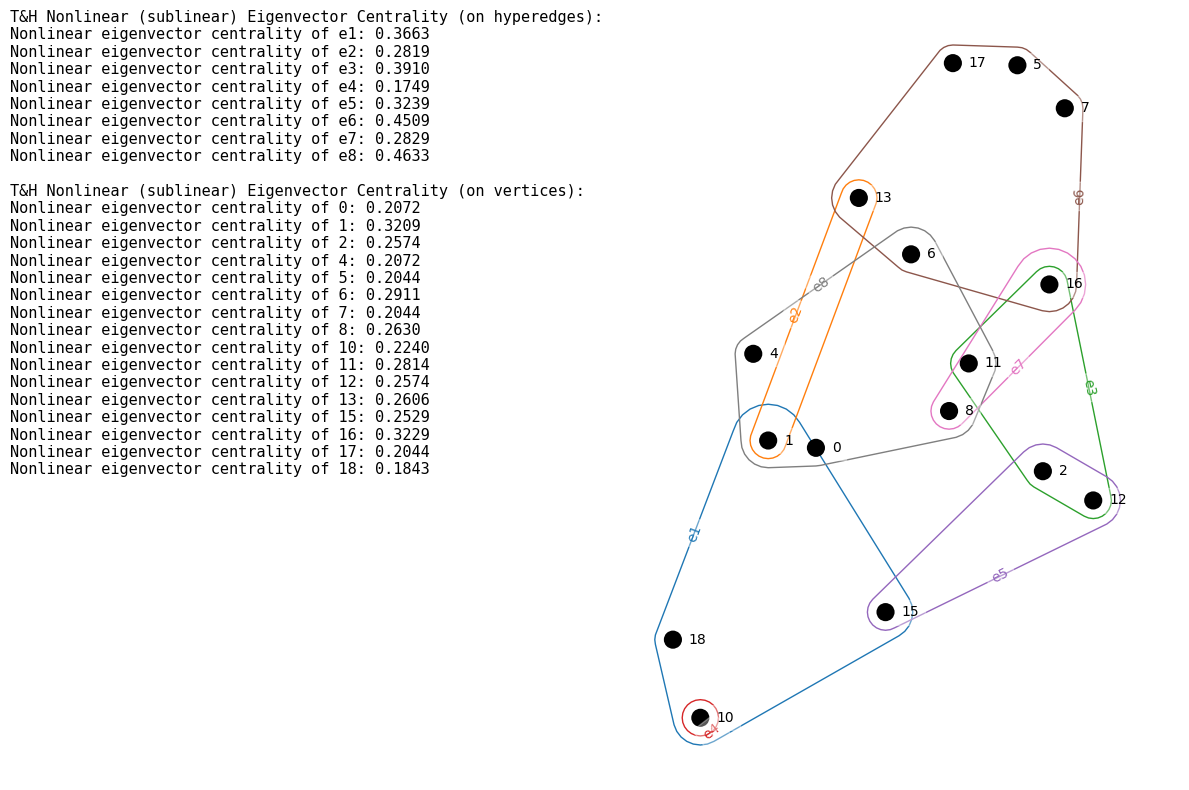

In [8]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break
print(hg_d)
H=hnx.Hypergraph(hg_d)        

alpha = 0.5
f = lambda x: x**alpha
node_centrality, edge_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("T&H Nonlinear (sublinear) Eigenvector Centrality (on hyperedges):")
for k,v in edge_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_output.append("\nT&H Nonlinear (sublinear) Eigenvector Centrality (on vertices):")
for k,v in node_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='7'></a>
## <span style="color:green">7. Tudisco and Higham Nonlinear (superlinear) Eigenvector Centrality</span>

{'e1': [1, 2, 9], 'e2': [3, 8, 10, 18], 'e3': [1, 17], 'e4': [5, 15, 17], 'e5': [13, 17, 19], 'e6': [2, 4, 5, 7, 9, 16], 'e7': [0, 9, 10, 12, 15, 19], 'e8': [1, 7]}


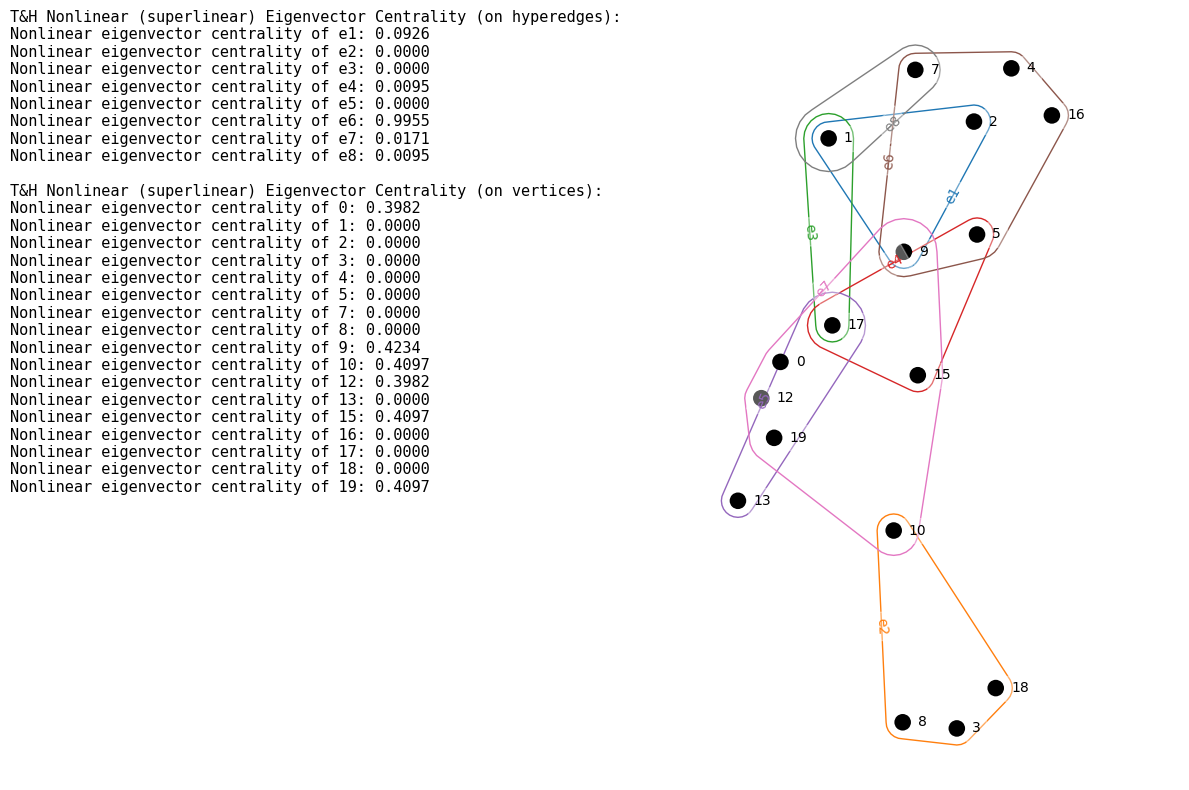

In [9]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break
print(hg_d)
H=hnx.Hypergraph(hg_d)        

alpha = 2.5
f = lambda x: x**alpha
node_centrality, edge_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("T&H Nonlinear (superlinear) Eigenvector Centrality (on hyperedges):")
for k,v in edge_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_output.append("\nT&H Nonlinear (superlinear) Eigenvector Centrality (on vertices):")
for k,v in node_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='8'></a>
## <span style="color:green">8. Tudisco and Higham Nonlinear (log plus one) Eigenvector Centrality</span>

{'e1': [1, 3, 11], 'e2': [7, 8], 'e3': [3, 7, 13, 14], 'e4': [5, 7, 9], 'e5': [11], 'e6': [0, 3, 9, 12, 18], 'e7': [0, 3, 4, 6, 8, 15], 'e8': [2, 9, 12, 18]}


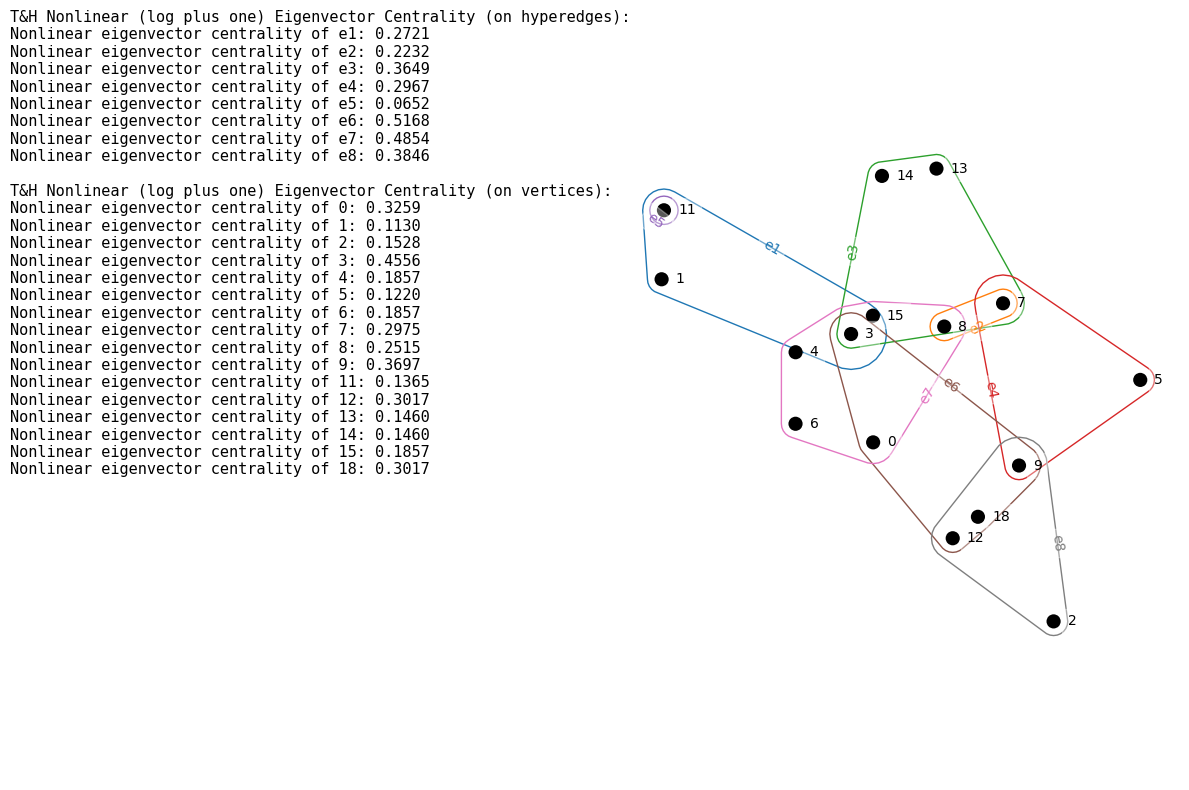

In [10]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(20)), hyperedge_names=[f"e{i+1}" for i in range(8)], m=8, minv=1, maxv=6, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break
print(hg_d)
H=hnx.Hypergraph(hg_d)        

f = (lambda x: math.log(x + 1) if x > -1 else None)
node_centrality, edge_centrality = TandH_nonlinear_hypergraph_centrality(hg_d, f)

fig = plt.figure(figsize=(12, 8))  
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4])  
ax1 = plt.subplot(gs[0])  
ax2 = plt.subplot(gs[1])  

text_output = []

text_output.append("T&H Nonlinear (log plus one) Eigenvector Centrality (on hyperedges):")
for k,v in edge_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_output.append("\nT&H Nonlinear (log plus one) Eigenvector Centrality (on vertices):")
for k,v in node_centrality.items():
     text_output.append(f"Nonlinear eigenvector centrality of {k}: {v:.4f}")
        
text_display = "\n".join(text_output)
ax1.text(0, 1, text_display, fontsize=11, verticalalignment="top", family="monospace")
ax1.axis("off")

hnx.draw(H, ax=ax2)

plt.tight_layout()
plt.show()

<a id='9'></a>
## <span style="color:green">9. All Centralities of a Random Hypergraph</span>

In [11]:
while True:
    hg_d=hypergraph_random_creator(vertices=list(range(50)), hyperedge_names=[f"e{i+1}" for i in range(20)], m=20, minv=1, maxv=15, mw=0)
    H=hnx.Hypergraph(hg_d)
    if is_connected(hg_d): 
        break
print(hg_d)

{'e1': [1, 8, 15, 26, 41, 42, 46, 47], 'e2': [6, 9, 10, 32], 'e3': [6, 7, 17, 22, 23, 27, 31, 37, 43, 44], 'e4': [6, 15, 31, 39, 49], 'e5': [0, 8, 18, 21, 27, 37, 38, 41, 42, 46], 'e6': [1, 3, 4, 6, 7, 12, 32, 42], 'e7': [6, 26, 27, 41, 48], 'e8': [13, 27, 34, 38], 'e9': [0, 5, 6, 16, 21, 26, 27, 29, 31, 38, 43, 44, 47], 'e10': [1, 2, 3, 5, 13, 21, 24, 25, 26, 27, 29, 30, 40, 48], 'e11': [0, 16, 21, 23, 39, 41, 42, 47], 'e12': [6, 22, 35, 40, 43, 47], 'e13': [3, 4, 6, 7, 15, 31, 43, 46], 'e14': [2, 4, 5, 8, 12, 17, 36, 46, 49], 'e15': [12, 29, 34], 'e16': [4, 24, 29, 31, 47], 'e17': [8, 9, 15, 17, 21, 27, 36, 48], 'e18': [29], 'e19': [20, 30, 38], 'e20': [2, 4, 6, 9, 14, 18, 19, 23, 34, 36]}


In [12]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=True).sort_values(by='Betweenness',ascending=False)
display(df.style.hide(axis="index"))

Hyperedge,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
e9,13,1.000000,0.111111,1,0.105342,0.316936
e10,14,0.904762,0.105263,2,0.073540,0.302911
e20,10,0.863636,0.102339,2,0.029555,0.250429
e16,5,0.760000,0.093567,2,0.026729,0.193031
e5,10,0.760000,0.093567,2,0.023225,0.269776
e6,8,0.826087,0.099415,2,0.021624,0.237588
e3,10,0.826087,0.099415,2,0.018973,0.268596
e7,5,0.791667,0.096491,2,0.014573,0.205114
e17,8,0.760000,0.093567,2,0.013687,0.242015
e8,4,0.655172,0.081871,2,0.011947,0.165900


In [13]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=False).sort_values(by='T&H Nonlinear Eigenvector',ascending=False)
display(df.style.hide(axis="index"))

Vertex,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
6,9,0.882353,0.245614,2,0.112844,0.245535
27,7,0.818182,0.233918,2,0.043364,0.226895
21,5,0.789474,0.228070,2,0.037117,0.199284
31,5,0.681818,0.201754,2,0.014370,0.188129
47,5,0.692308,0.204678,2,0.019905,0.185851
4,5,0.692308,0.206628,3,0.026634,0.184900
26,4,0.703125,0.207602,2,0.013746,0.176205
29,5,0.681818,0.201754,2,0.013971,0.173683
43,4,0.671642,0.198830,2,0.013774,0.173496
46,4,0.692308,0.204678,2,0.012010,0.171188


<a id='10'></a>
## <span style="color:green">10. All Centralities of the Southern Women Hypergraph</span>

In [14]:
G=nx.davis_southern_women_graph()
bottom_nodes, top_nodes = bipartite.sets(G)
hg_d={e: list(G.neighbors(e)) for e in top_nodes}
print(hg_d)

{'E4': ['Evelyn Jefferson', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd'], 'E1': ['Evelyn Jefferson', 'Laura Mandeville', 'Brenda Rogers'], 'E12': ['Verne Sanderson', 'Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd'], 'E14': ['Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette'], 'E3': ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Frances Anderson'], 'E7': ['Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Eleanor Nye', 'Ruth DeSand', 'Verne Sanderson', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd'], 'E10': ['Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd'], 'E6': ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Frances Anderson', 'Eleanor Nye', 'Pearl Oglethorpe', 'Nora Fayette'], 'E8': ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Frances Anderson', 'Eleanor 

In [15]:
df1=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=True) #.sort_values(by='Betweenness',ascending=False)
display(df1.style.hide(axis="index"))

Hyperedge,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
E4,4,0.722222,0.134615,2,0.000000,0.220130
E1,3,0.722222,0.134615,2,0.000000,0.194969
E12,6,0.722222,0.134615,2,0.000000,0.257765
E14,3,0.722222,0.134615,2,0.000000,0.189909
E3,6,0.722222,0.134615,2,0.000000,0.265994
E7,10,1.000000,0.166667,1,0.080128,0.337246
E10,5,0.722222,0.134615,2,0.000000,0.237243
E6,8,1.000000,0.166667,1,0.080128,0.305256
E8,14,1.000000,0.166667,1,0.080128,0.390251
E11,4,0.722222,0.134615,2,0.000000,0.189664


In [16]:
df2=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=False) #.sort_values(by='Betweenness',ascending=False)
display(df2.style.hide(axis="index"))

Vertex,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
Brenda Rogers,7,0.894737,0.205128,2,0.002674,0.277499
Katherina Rogers,6,0.944444,0.211538,2,0.005348,0.248377
Pearl Oglethorpe,3,0.944444,0.211538,2,0.005348,0.199835
Flora Price,2,0.772727,0.185897,2,0.000000,0.143566
Sylvia Avondale,7,1.000000,0.217949,1,0.010122,0.273082
Charlotte McDowd,4,0.739130,0.179487,2,0.000000,0.207341
Ruth DeSand,4,1.000000,0.217949,1,0.010122,0.229552
Evelyn Jefferson,8,1.000000,0.217949,1,0.010122,0.291614
Verne Sanderson,4,1.000000,0.217949,1,0.010122,0.225837
Myra Liddel,4,0.944444,0.211538,2,0.005348,0.217215


In [17]:
col_dicts = {}
for col in list(df1.columns)[1:]:  # Skip the 'Hyperedge' column
    col_dicts[col] = {**col_dicts.get(col, {}), **df2dict(df1, "Hyperedge", col)}
for col in list(df2.columns)[1:]:  # Skip the 'Vertex' column
    col_dicts[col] = {**col_dicts.get(col, {}), **df2dict(df2, "Vertex", col)}

if isinstance(df1['Hyperedge'].iloc[0], str) or isinstance(df2['Vertex'].iloc[0], str):
    mapping = {i: str(i) for i in G.nodes}  # Convert integer labels to strings
    G = nx.relabel_nodes(G, mapping)

selected_centrality = 'Closeness'  # Change this to any centrality in df1 or df2
cent_d = col_dicts.get(selected_centrality, {})  # Get the dictionary for the selected centrality

if cent_d:
    cmap = plt.get_cmap('Reds')  # Choose a colormap
    node_values = list(cent_d.values())
    normalize = plt.Normalize(vmin=min(node_values), vmax=max(node_values))
    node_colors = {node: cmap(normalize(value)) for node, value in cent_d.items()}
    node_colors_hex = {node: f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for node, (r, g, b, _) in node_colors.items()}
else:
    node_colors_hex = {}

net = Network(notebook=True, height="500px", width="100%", cdn_resources='in_line')
net.from_nx(G)

x_offset = 100  # Horizontal spacing between columns
y_offset = 50   # Vertical spacing between nodes

hyperedge_nodes = set(df1['Hyperedge'])  # Nodes in the hyperedge partition
vertex_nodes = set(df2['Vertex'])        # Nodes in the vertex partition

for i, node in enumerate(hyperedge_nodes):
    net.get_node(node)['x'] = -500
    net.get_node(node)['y'] = i * y_offset

for i, node in enumerate(vertex_nodes):
    net.get_node(node)['x'] = x_offset
    net.get_node(node)['y'] = i * y_offset

for node in G.nodes:
    if node in node_colors_hex:  # Check if the node exists in the selected centrality dictionary
        net.get_node(node)['color'] = node_colors_hex[node]
    
    # Construct the tooltip dynamically to include all centralities
    tooltip_lines = [f"Node: {node}"]
    for col, centrality_dict in col_dicts.items():
        if node in centrality_dict:  # Check if the node exists in the centrality dictionary
            tooltip_lines.append(f"{col}: {centrality_dict[node]:.4f}")
    
    # Join the lines with newline characters
    net.get_node(node)['title'] = "\n".join(tooltip_lines)

net.set_options("""
{
  "physics": {
    "enabled": false
  }
}
""")

net.show("SouthernWomen_closeness_colored_graph.html")

SouthernWomen_closeness_colored_graph.html


<a id='11'></a>
## <span style="color:green">11. All Centralities of the Karate Club Clique-Based Hypergraph</span>

In [18]:
G = nx.karate_club_graph()
cliques = find_maximal_cliques(G)
hg_d = {f"clique_{i}": clique for i, clique in enumerate(cliques)}
print(hg_d)

{'clique_0': [0, 1, 2, 3, 13], 'clique_1': [0, 1, 2, 3, 7], 'clique_2': [8, 30, 32, 33], 'clique_3': [23, 29, 32, 33], 'clique_4': [0, 1, 17], 'clique_5': [0, 1, 19], 'clique_6': [0, 1, 21], 'clique_7': [0, 4, 10], 'clique_8': [0, 4, 6], 'clique_9': [0, 5, 10], 'clique_10': [0, 5, 6], 'clique_11': [0, 2, 8], 'clique_12': [0, 3, 12], 'clique_13': [2, 8, 32], 'clique_14': [5, 6, 16], 'clique_15': [14, 32, 33], 'clique_16': [15, 32, 33], 'clique_17': [18, 32, 33], 'clique_18': [20, 32, 33], 'clique_19': [22, 32, 33], 'clique_20': [31, 32, 33], 'clique_21': [26, 29, 33], 'clique_22': [23, 27, 33], 'clique_23': [28, 31, 33], 'clique_24': [24, 25, 31], 'clique_25': [0, 11], 'clique_26': [0, 31], 'clique_27': [1, 30], 'clique_28': [2, 9], 'clique_29': [2, 27], 'clique_30': [2, 28], 'clique_31': [9, 33], 'clique_32': [13, 33], 'clique_33': [19, 33], 'clique_34': [24, 27], 'clique_35': [23, 25]}


In [19]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=True) #.sort_values(by='Betweenness',ascending=False)
display(df.style.hide(axis="index"))

Hyperedge,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
clique_0,5,0.660377,0.044258,3,0.090661,0.225430
clique_1,5,0.636364,0.043137,3,0.050301,0.222287
clique_2,4,0.636364,0.042577,3,0.058284,0.205642
clique_3,4,0.538462,0.039356,4,0.017288,0.204923
clique_4,3,0.514706,0.037255,3,0.003209,0.173056
clique_5,3,0.603448,0.040616,3,0.040862,0.177462
clique_6,3,0.514706,0.037255,3,0.003209,0.173056
clique_7,3,0.507246,0.036415,3,0.000000,0.163653
clique_8,3,0.514706,0.037255,3,0.017927,0.167007
clique_9,3,0.514706,0.037255,3,0.017927,0.167007


In [20]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=False) #.sort_values(by='Betweenness',ascending=False)
display(df.style.hide(axis="index"))

Vertex,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
0,13,0.568966,0.038936,3,0.437635,0.359984
1,6,0.485294,0.032213,3,0.053937,0.250050
2,7,0.559322,0.035294,3,0.143657,0.261044
3,3,0.464789,0.029692,3,0.011909,0.186659
4,2,0.379310,0.024650,4,0.000631,0.137141
5,3,0.383721,0.025490,4,0.029987,0.163406
6,3,0.383721,0.025490,4,0.029987,0.163406
7,1,0.440000,0.027591,4,0.000000,0.112444
8,3,0.515625,0.031092,3,0.055927,0.179677
9,2,0.434211,0.026190,4,0.000848,0.124536


In [21]:
col_dicts = {}
for col in list(df.columns)[1:]:  
    col_dicts[col] = df2dict(df, "Vertex", col)

if isinstance(df['Vertex'].iloc[0], str):
    mapping = {i: str(i) for i in G.nodes}  
    G = nx.relabel_nodes(G, mapping)

selected_centrality = 'T&H Nonlinear Eigenvector'  
cent_d = col_dicts[selected_centrality]  

cmap = matplotlib.colormaps['Blues']  
node_values = list(cent_d.values())
normalize = plt.Normalize(vmin=min(node_values), vmax=max(node_values))
node_colors = [cmap(normalize(value)) for value in node_values]
node_colors_hex = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b, _ in node_colors]

net = Network(notebook=True, height="500px", width="100%", cdn_resources='in_line')
net.from_nx(G)

for node in G.nodes:
    if node in cent_d:  
        net.get_node(node)['color'] = node_colors_hex[list(cent_d.keys()).index(node)]
    tooltip_lines = [f"Node: {node}"]
    for col, centrality_dict in col_dicts.items():
        if node in centrality_dict: 
            tooltip_lines.append(f"{col}: {centrality_dict[node]:.4f}")
    net.get_node(node)['title'] = "\n".join(tooltip_lines)

net.show("Karate_betweenness_colored_graph.html")

Karate_betweenness_colored_graph.html


<a id='12'></a>
## <span style="color:green">12. All Centralities of the Les Miserable Clique-Based Hypergraph</span>

In [22]:
G = nx.les_miserables_graph()
cliques = find_maximal_cliques(G)
hg_d = {f"clique_{i}": clique for i, clique in enumerate(cliques)}
print(hg_d)

{'clique_0': ['Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Joly', 'Mabeuf', 'Marius'], 'clique_1': ['Bahorel', 'Bossuet', 'Combeferre', 'Courfeyrac', 'Enjolras', 'Feuilly', 'Gavroche', 'Grantaire', 'Joly', 'Prouvaire'], 'clique_2': ['Blacheville', 'Dahlia', 'Fameuil', 'Fantine', 'Favourite', 'Listolier', 'Tholomyes', 'Zephine'], 'clique_3': ['Bahorel', 'Bossuet', 'Courfeyrac', 'Enjolras', 'Gavroche', 'Grantaire', 'Joly', 'MmeHucheloup'], 'clique_4': ['Bamatabois', 'Brevet', 'Champmathieu', 'Chenildieu', 'Cochepaille', 'Judge', 'Valjean'], 'clique_5': ['Babet', 'Claquesous', 'Gueulemer', 'Javert', 'MmeThenardier', 'Thenardier', 'Valjean'], 'clique_6': ['Babet', 'Claquesous', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'], 'clique_7': ['Babet', 'Gavroche', 'Gueulemer', 'Javert', 'Montparnasse', 'Thenardier', 'Valjean'], 'clique_8': ['Babet', 'Brujon', 'Claquesous', 'Eponine', 'Gueulemer', 'Montparnasse', 'Thenardier'], 'clique_9':

In [23]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=True) #.sort_values(by='Betweenness',ascending=False)
display(df.style.hide(axis="index"))

Hyperedge,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
clique_0,10,0.542056,0.022283,3,0.029916,0.198286
clique_1,10,0.483333,0.019359,3,0.000925,0.188256
clique_2,8,0.449612,0.017493,4,0.001012,0.127018
clique_3,8,0.483333,0.019359,3,0.000925,0.172240
clique_4,7,0.617021,0.024803,3,0.000000,0.141401
clique_5,7,0.682353,0.027324,3,0.022755,0.202586
clique_6,7,0.674419,0.027022,3,0.015108,0.201465
clique_7,7,0.734177,0.028736,2,0.046815,0.205014
clique_8,7,0.513274,0.020871,3,0.001048,0.177724
clique_9,6,0.542056,0.022484,3,0.010467,0.170604


In [24]:
df=hypergraph_centralities(hypergraph=hg_d, f = lambda x: x**0.5, edges=False) #.sort_values(by='Betweenness',ascending=False)
display(df.style.hide(axis="index"))

Vertex,Degree,Closeness,Harmonic Closeness,Eccentricity,Betweenness,T&H Nonlinear Eigenvector
MmeBurgon,2,0.343891,0.017342,4,0.026316,0.065726
Marius,11,0.531469,0.027727,3,0.132032,0.221652
Bossuet,4,0.475000,0.024803,3,0.030754,0.150468
Gueulemer,6,0.463415,0.023795,3,0.004960,0.187187
Fantine,6,0.460606,0.024803,4,0.129645,0.158492
Babet,6,0.463415,0.023795,3,0.004960,0.187187
Jondrette,1,0.256757,0.012613,5,0.000000,0.040363
Feuilly,2,0.391753,0.021426,4,0.001250,0.109544
Courfeyrac,4,0.400000,0.022232,4,0.005267,0.145990
Enjolras,6,0.481013,0.025408,3,0.042553,0.180370


In [25]:
col_dicts = {}
for col in list(df.columns)[1:]:  
    col_dicts[col] = df2dict(df, "Vertex", col)

if isinstance(df['Vertex'].iloc[0], str):
    mapping = {i: str(i) for i in G.nodes}  
    G = nx.relabel_nodes(G, mapping)

selected_centrality = 'T&H Nonlinear Eigenvector'  
cent_d = col_dicts[selected_centrality]  

cmap = matplotlib.colormaps['Blues']  
node_values = list(cent_d.values())
normalize = plt.Normalize(vmin=min(node_values), vmax=max(node_values))
node_colors = [cmap(normalize(value)) for value in node_values]
node_colors_hex = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b, _ in node_colors]

net = Network(notebook=True, height="500px", width="100%", cdn_resources='in_line')
net.from_nx(G)

for node in G.nodes:
    if node in cent_d:  
        net.get_node(node)['color'] = node_colors_hex[list(cent_d.keys()).index(node)]
    tooltip_lines = [f"Node: {node}"]
    for col, centrality_dict in col_dicts.items():
        if node in centrality_dict: 
            tooltip_lines.append(f"{col}: {centrality_dict[node]:.4f}")
    net.get_node(node)['title'] = "\n".join(tooltip_lines)

net.show("LesMiserables_eigenvector_colored_graph.html")

LesMiserables_eigenvector_colored_graph.html
